In [3]:
import pandas as pd 
import numpy as np 
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [6]:
default_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = default_dir + "test/"
train_dir = default_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']


In [7]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [9]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [10]:
train_dataset = image_generator.flow_from_directory(batch_size=6500,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)


Found 6400 images belonging to 4 classes.


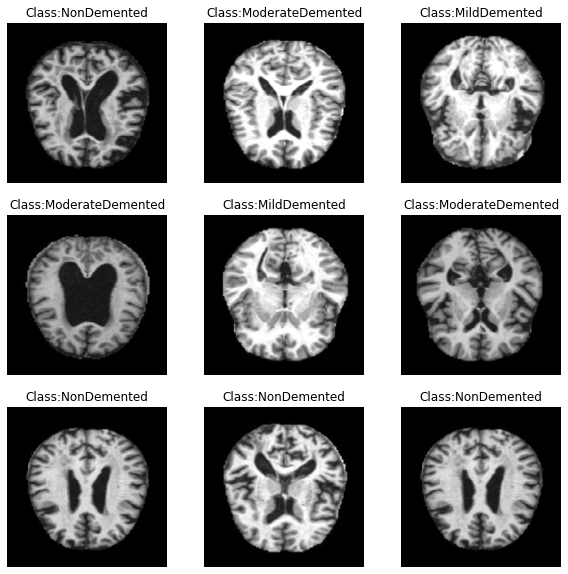

In [16]:
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x,y = generator.next()
    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

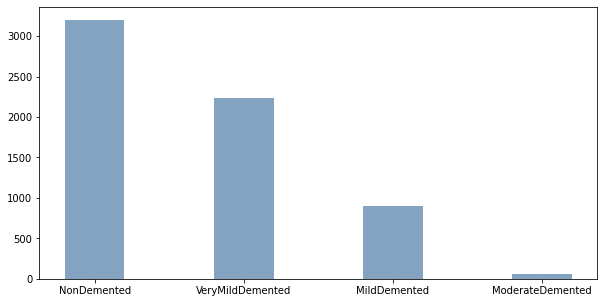

In [10]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

In [11]:
train_data, train_labels = train_dataset.next()

In [12]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [13]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [15]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

## ANN

In [15]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [176,176,3]),  
keras.layers.Dense(100, activation = 'relu' ),                               
keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),

keras.layers.Dense(200, activation = 'relu' ),
keras.layers.Dense(4, activation = 'softmax')])

In [16]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

In [17]:
model.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])

In [18]:
result = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
256/256 [==============================] - 7s 18ms/step - loss: 1.2590 - auc: 0.7735 - val_loss: 0.7385 - val_auc: 0.8905
Epoch 2/50
256/256 [==============================] - 3s 11ms/step - loss: 0.8257 - auc: 0.8700 - val_loss: 0.7422 - val_auc: 0.8928
Epoch 3/50
256/256 [==============================] - 3s 12ms/step - loss: 0.7408 - auc: 0.8918 - val_loss: 0.7685 - val_auc: 0.8864
Epoch 4/50
256/256 [==============================] - 3s 11ms/step - loss: 0.7009 - auc: 0.9024 - val_loss: 0.6670 - val_auc: 0.9131
Epoch 5/50
256/256 [==============================] - 3s 11ms/step - loss: 0.6741 - auc: 0.9111 - val_loss: 0.7118 - val_auc: 0.9016
Epoch 6/50
256/256 [==============================] - 3s 12ms/step - loss: 0.6521 - auc: 0.9174 - val_loss: 0.5988 - val_auc: 0.9295
Epoch 7/50
256/256 [==============================] - 3s 13ms/step - loss: 0.6407 - auc: 0.9208 - val_loss: 0.5946 - val_auc: 0.9322
Epoch 8/50
256/256 [==============================] - 3s 11ms/step - 

In [19]:
loss, accuracy = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

80/80 [==============================] - 1s 8ms/step - loss: 0.5686 - auc: 0.9364
Loss:  0.5685562491416931
Accuracy:  0.9363932609558105


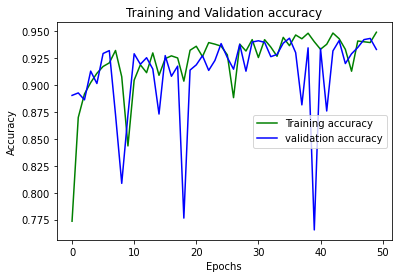

In [20]:
loss_train = result.history['auc']
loss_val = result.history['val_auc']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



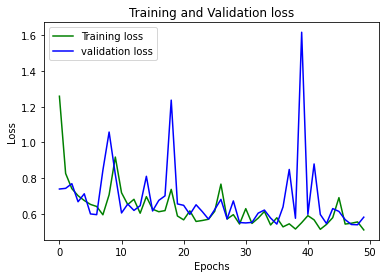

In [21]:
loss_train = result.history['loss']
loss_val = result.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## CNN

In [16]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

In [17]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.AUC(name='auc')]
    )

In [19]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
164/164 [==============================] - 23s 53ms/step - loss: 1.8464 - auc: 0.5233 - val_loss: 1.4127 - val_auc: 0.4828
Epoch 2/50
164/164 [==============================] - 7s 41ms/step - loss: 1.4977 - auc: 0.5902 - val_loss: 1.5133 - val_auc: 0.5108
Epoch 3/50
164/164 [==============================] - 7s 42ms/step - loss: 1.3123 - auc: 0.6671 - val_loss: 1.5278 - val_auc: 0.5232
Epoch 4/50
164/164 [==============================] - 7s 44ms/step - loss: 1.1785 - auc: 0.7381 - val_loss: 1.3591 - val_auc: 0.6674
Epoch 5/50
164/164 [==============================] - 7s 41ms/step - loss: 0.9040 - auc: 0.8527 - val_loss: 1.7501 - val_auc: 0.6846
Epoch 6/50
164/164 [==============================] - 7s 41ms/step - loss: 0.7846 - auc: 0.8866 - val_loss: 0.6952 - val_auc: 0.9031
Epoch 7/50
164/164 [==============================] - 7s 42ms/step - loss: 0.7400 - auc: 0.8981 - val_loss: 1.1098 - val_auc: 0.8152
Epoch 8/50
164/164 [==============================] - 7s 41ms/step -

In [21]:
loss, accuracy = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

52/52 [==============================] - 1s 11ms/step - loss: 1.4560 - auc: 0.8790
Loss:  1.4560359716415405
Accuracy:  0.8789690136909485


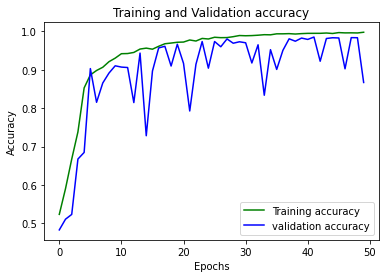

In [23]:
loss_train = history.history['auc']
loss_val = history.history['val_auc']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


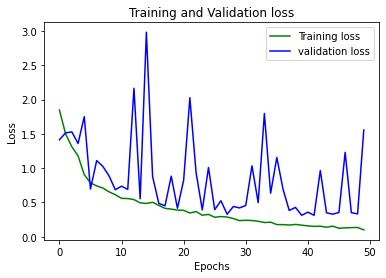

In [25]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()